# PHYS-E0412 Computational Physics :: Homework 8
Ari Viitala 432568

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
import scipy
from IPython import display

### a) Implement a finite-element solver for the eigenvalue problem

In [2]:
#potential function
def pot(s):
    return -150*np.exp(-40*(s -0.25)**2)-50*np.exp(-10*(s-0.75)**2)

#the basis hat function as per lecture slides
def bas(s, i, x):
    bas1 = 0
    
    if s > x[i - 1] and s <= x[i]:
        bas1 = (s - x[i-1]) / (x[i] - x[i-1])
    elif s > x[i] and s < x[i+1]:
        bas1 = (x[i+1] - s) / (x[i + 1] - x[i])
    
    return bas1

In [3]:
#solves the 1d eigenvalue problem for the Schrödinger equation
def d1_schrodde(x):
    #allocate the matrices
    N = len(x)
    T = np.zeros((N,N))
    V = np.zeros((N,N))
    S = np.zeros((N,N))
    H = np.zeros((N,N))
    
    for i in range(1,N-1):
        #intervals before and after x[i]
        hi = x[i] - x[i-1] 
        hj = x[i+1] - x[i]
        
        #populate matrix S
        S[i,i-1] = 1/6 * hi
        S[i,i] = 1/3 * (hi + hj)
        S[i,i+1] = 1/6 * hj

        #populate matrixa T
        T[i, i] = 1 / hi + 1/hj
        T[i, i - 1] =  -1 / hi
        T[i, i + 1] = -1 / hj
        
        #populate matrix V
        #Since the hat functions are zeros far away from the point we don't
        #have to integrate always from 0 to 1 and the matrix has a tridiagonal nature
        left = x[max(0, i - 2)]
        right = x[min(N-1, i + 2)]
        V[i, i -1] = quad(lambda a: bas(a,i, x) * pot(a) * bas(a, i-1, x), left, right)[0] 
        V[i, i] = quad(lambda a: bas(a,i, x) * pot(a) * bas(a, i, x), left, right)[0] 
        V[i, i +1] = quad(lambda a: bas(a,i, x) * pot(a) * bas(a, i+1, x), left, right)[0]

    #scale matrix T
    T *= 0.5
    
    #Calculate the Hamiltonian
    H = T + V
    
    #Solve the eigenvalu problem and return the eigenvalues and vectors
    a, b = scipy.linalg.eigh(H[1:N-1,1:N-1], S[1:N-1,1:N-1])
    
    return a, b

Solving the problem with 1000 points.

In [4]:
N = 1000
x = np.linspace(0, 1, N)

l, v = d1_schrodde(x)

In [5]:
l[:5]

array([-107.47643896,  -38.58114077,  -21.96929544,   15.50934964,
         59.72857878])

It seems that the first three eigenvalues are negative.

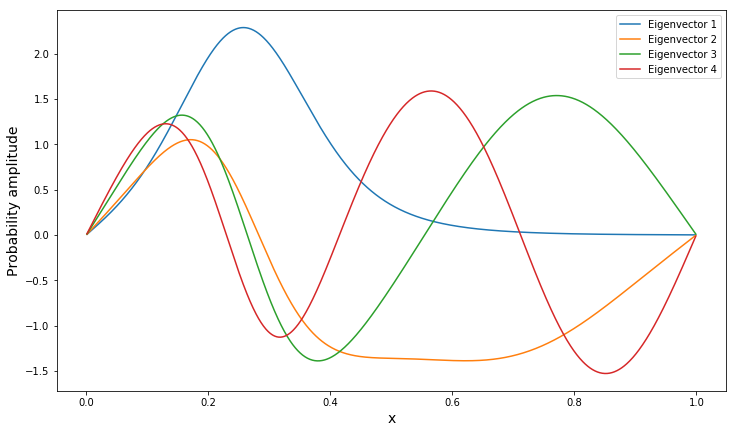

In [6]:
plt.figure(1, (12, 7))
for i in range(4):
    plt.plot(x[1:-1], v[:,i], label = "Eigenvector " + str(i + 1))
    
plt.xlabel("x", size = 14)
plt.ylabel("Probability amplitude", size = 14)
plt.legend()
plt.show()

**Note:** _Here it is fine to just plot the eigenvectors since our basisfunctions are just hats that have the height of one so the eigenfunction and vector are the same thing. If we used for example a sinusoidal basis then we of course would have to calculate the actual function from our basis functions._

### b) Plot some of the lowest eigenfunctions. Given a budget of N = 30 nodes devise a more effective placement to approximate the lowest eigenpair.
If we plot the lowest eigenvectors we see that the first eigenvalue has distinct peak at about 0.25 where the beahavior is not at all linear where the behavior of the eigenfunction is not at all linear. However, there are also long intervals where the behavior of the eigenfunction is almost linear.

Here we are using linear hat functions so they appoximate linear parts perfectly, hence, we can do with a sparser grid but at intervals where the behavior is not linear we need a tighter grid.

Let's first try with an uniform grid so that we can benchmark our solution.

In [21]:
linear_x = np.linspace(0, 1, 30)
l3, v3 = d1_schrodde(linear_x)

In [22]:
l3[0] - l[0]

0.2464723859905149

In [29]:
interp = interpolate.interp1d(x, [0] + list(v[:, 0]) + [1])
interpolated = interp(linear_x)

np.linalg.norm(np.array(np.array([0] + list(v3[:,0]) + [1]) - interpolated))

0.02240487179353062

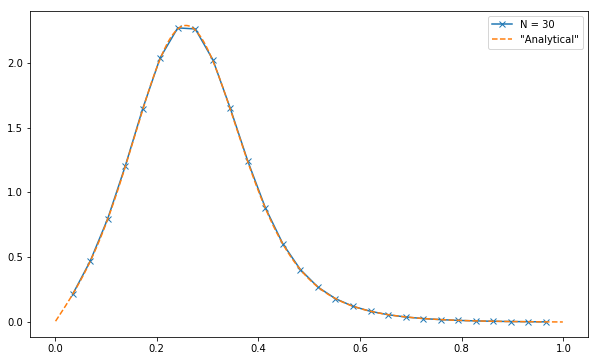

In [9]:
plt.figure(0, (10, 6))
plt.plot(linear_x[1:-1], v3[:,0], marker = "x", label = "N = 30")
plt.plot(x[1:-1], v[:,0], label = "\"Analytical\"", linestyle = "--")

plt.legend()
plt.show()

We see that the uniform grid manages pretty well but it has difficulties especially at the maximum value. The difference in minimal energy is about 0.25.

Now if we adjust the point spacing such that we focus on the non-linear parts we can expect to see some improvement. This step was done by uploading the plot of the lowes eigenvector to an image manipulating software an picking suitable pixel values for a more optimized grid.

In [10]:
#pixel values
manual_x = [0,9,19,29,35,57,65,67,71,73,76,77,78,79,80,83,87,93,105,120,128,138,144,153,166,175,193,217,238,305]
#scaling to interval [0, 1]
manual_x = np.array(manual_x) / manual_x[-1]

In [11]:
len(manual_x)

30

In [12]:
l2, v2 = d1_schrodde(manual_x)

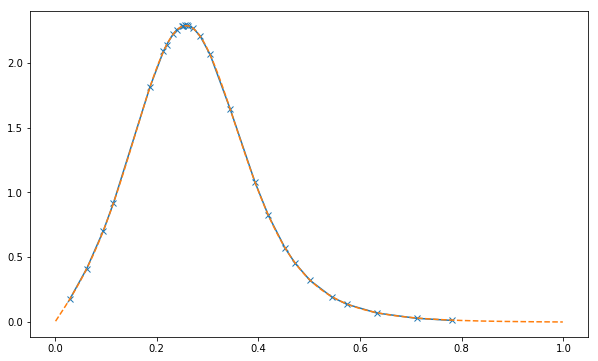

In [13]:
plt.figure(0, (10, 6))
plt.plot(manual_x[1:-1], v2[:, 0], marker = "x")
plt.plot(x[1:-1], v[:,0], linestyle = "--")

In [30]:
l2[0] - l[0]

0.0902134970941546

In [31]:
interp = interpolate.interp1d(x, [0] + list(v[:, 0]) + [1])
interpolated = interp(manual_x)

np.linalg.norm(np.array(np.array([0] + list(v2[:,0]) + [1]) - interpolated))

0.009655835108450788

We can see that with a grid spacing that focuses on the problem areas we can more than half our error for the lowest energy. Also the norm of the solution vector difference goes down a comparable amount.

I tested different point configurations that focused more or less on the energy minimum. It seemed that increasing the amount of points at the energy minimum does not imporve the minimum energy past some point and it is also necessary to have decent coverage at on other points of the interval.

### c) I used about 8 hours for this exercise.